# SPISEA with COSMIC

This is a quick tutorial to use SPISEA with COSMIC. COSMIC is a rapid binary synthesis code. We use it to evolve singles and binaries generated in a SPISEA cluster. In order to use this functionality, the user must install COSMIC. Info about installation and COSMIC usage can be found here: https://cosmic-popsynth.github.io/COSMIC/index.html

Tutorial by Natasha Abrams 1-27-26

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from spisea import synthetic, evolution, atmospheres, reddening, ifmr, filters
from spisea.imf import imf, multiplicity
import os
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np

You can start by instantiating a SPISEA isochrone object as usual, with a few key differences:
- Evolution object is COSMIC. This takes the dictionary specifying the binary evolution parameters. For detailed instructions on changing the parameters in this dictionary see the [COSMIC docs](https://github.com/COSMIC-PopSynth/COSMIC/blob/v3.6.1/examples/Params.ini).
- You can also specify if you'd like to keep disrupted companions which will be added to the primary table or if you would like them to be dropped. We recommend keeping them and this is the default.
- We use the IsochronePhotExternalEvolution() object as the ischrone object. We name it this way for convention, but COSMIC does not use an Isochrone grid like the other evolution models in SPISEA. Instead it uses prescriptions from Hurley et al. 2002.
- Since no isochrones are used, we interpolate over every point in Teff, logg, and metallicity for the atmospehre grids. This takes longer than the typical generation of isocrhones in SPISEA, but will have to be done less frequently.
- We suggest having a separate directory than your typical isochrone directory where the atmosphere grids will be stored.
- We recommend using get_merged_atmsophere_w_bb_supplement since some objects generated by COSMIC are outside of supported SPISEA atmospheres. You can specify your own ranges to have black bodies defined or use our default ones.

In [3]:
# Fetch isochrone
logAge = 10 # Age in log(years)
AKs = 0 # Ks filter extinction in mags
dist = 4000 # distance in parsecs
metallicity = 0 # metallicity in [M/H]
atm_func = atmospheres.get_merged_atmosphere_w_bb_supplement
evo_merged = evolution.COSMIC(keep_COSMIC_tables=True)
redlaw = reddening.RedLawCardelli(3.1) # Rv = 3.1
filt_list = ['ubv,U', 'ubv,V', 'ubv,R']

iso_dir = 'iso_cosmic/'

if not os.path.exists(iso_dir):
        os.mkdir(iso_dir)

iso = synthetic.IsochronePhotExternalEvolution(logAge, AKs, dist, metallicity=metallicity,
                                 evo_model=evo_merged, atm_func=atm_func,
                                 filters=filt_list, red_law=redlaw,
                                 atm_grid_dir=iso_dir, mass_sampling=3, recomp=False)

Next we can make the cluster. You must specify a resolved multiplicity object (i.e. with orbital parameters defined) and with a CSF_max = 1 and companion_max = True. This ensures there are only binaries and no higher order systems since COSMIC does not support them.

In [4]:
# Now we can make the cluster. 
clust_mtot = 10**4.
clust_multiplicity = multiplicity.MultiplicityResolvedDK(CSF_max = 1, companion_max = True)

# Multiplicity is defined in the IMF object
clust_imf_Mult = imf.Kroupa_2001(multiplicity=clust_multiplicity)

In [5]:
# Make cluster
clust_cosmic = synthetic.ResolvedCluster(iso, clust_imf_Mult, clust_mtot)

/opt/mambaforge3/envs/astro_cosmic/lib/python3.11/site-packages/cosmic/utils.py:1687: UserWarning: At least one of your initial binaries is starting in Roche Lobe Overflow:
       kstar_1  kstar_2      mass_1     mass_2      porb       ecc  \
582        1.0      1.0  116.027861  92.484134  0.862282  0.840790   
917        1.0      1.0   93.249056   4.880100  0.984959  0.126383   
2054       1.0      1.0  122.595315  67.697527  0.029709  0.860986   
2936       1.0      0.0   28.512173   0.644606  0.185955  0.828483   
3949       1.0      1.0   36.708844   5.099184  0.068500  0.415908   
4473       1.0      1.0   11.901563   1.191013  0.500548  0.947242   
4898       1.0      1.0   27.121218  16.036259  0.185669  0.730699   
4981       1.0      1.0    7.524916   4.762153  0.113632  0.507614   
7111       1.0      0.0    2.294603   0.462178  0.382382  0.728774   
12445      1.0      1.0   13.812780   8.529573  0.096521  0.905398   
13443      1.0      1.0   33.070690   8.437323  0.108757 

If you specified `keep_COSMIC_tables=True`, then you can access the COSMIC tables as described here: https://cosmic-popsynth.github.io/COSMIC/pages/output_info.html#output-info

In [6]:
bcm_table = clust_cosmic.iso.evo_model.bcm
bpp_table = clust_cosmic.iso.evo_model.bpp

# Example analysis plots

CMD

Text(0, 0.5, 'm_ubv_R')

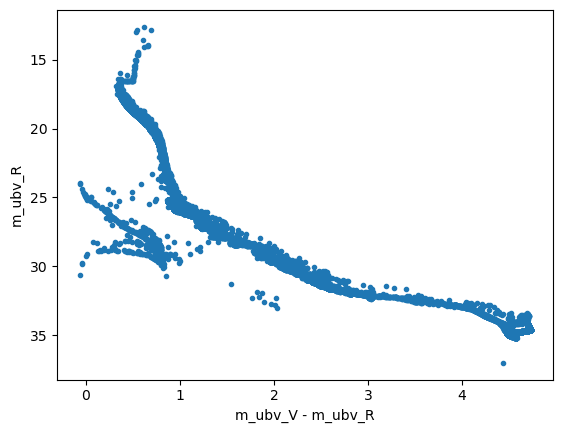

In [7]:
plt.plot(clust_cosmic.star_systems['m_ubv_V'] - clust_cosmic.star_systems['m_ubv_R'], clust_cosmic.star_systems['m_ubv_R'], marker = '.', linestyle = 'None')
plt.gca().invert_yaxis()
plt.xlabel('m_ubv_V - m_ubv_R')
plt.ylabel('m_ubv_R')

Text(0.5, 1.0, 'Singles Only')

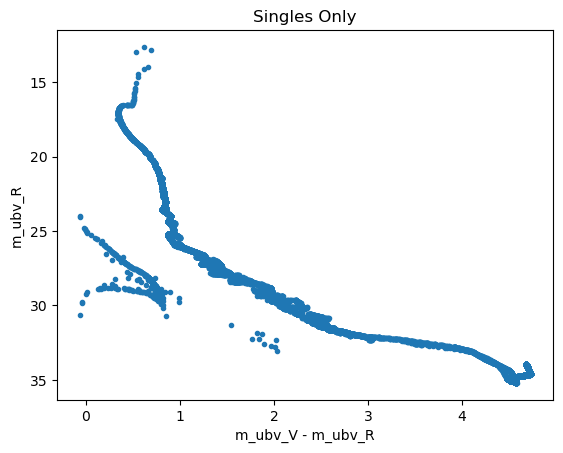

In [8]:
plt.plot(clust_cosmic.star_systems['m_ubv_V'][clust_cosmic.star_systems['isMultiple'] == 0] - clust_cosmic.star_systems['m_ubv_R'][clust_cosmic.star_systems['isMultiple'] == 0], clust_cosmic.star_systems['m_ubv_R'][clust_cosmic.star_systems['isMultiple'] == 0], marker = '.', linestyle = 'None')
plt.gca().invert_yaxis()
plt.xlabel('m_ubv_V - m_ubv_R')
plt.ylabel('m_ubv_R')
plt.title('Singles Only')

Semimajor axis distribution. Note this goes down to lower semimajor axes than when we evolve each star individual since binary interaction is now taken into account.

Text(0.5, 0, 'log(a) [AU]')

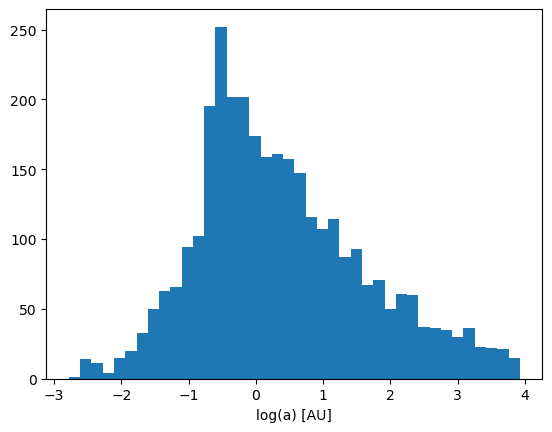

In [9]:
plt.hist(clust_cosmic.companions['log_a'], bins = 40)
plt.xlabel('log(a) [AU]')

Kick distribution. We add the kicks from COSMIC which come from supernovae prescriptions and account for if the objects are disrupted or not.

Text(0, 0.5, 'N objects')

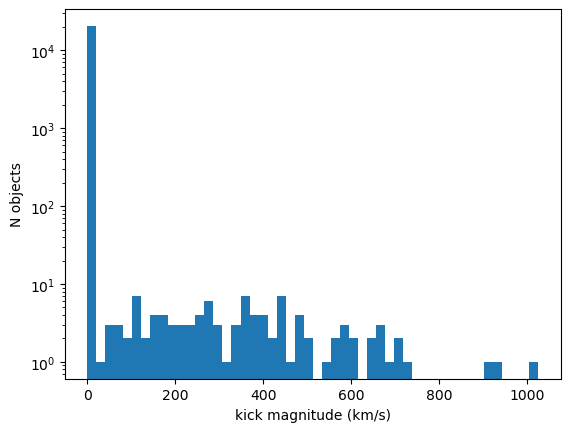

In [10]:
plt.hist(clust_cosmic.star_systems['kick'], bins = 50)
plt.xlabel('kick magnitude (km/s)')
plt.yscale('log')
plt.ylabel('N objects')

# Check interpolation over atmosphere grid

In [11]:
from scipy.interpolate import LinearNDInterpolator

In [12]:
interp = LinearNDInterpolator((clust_cosmic.iso.points['Teff'], clust_cosmic.iso.points['logg']), clust_cosmic.iso.points['m_ubv_R'],
                                                                fill_value=np.nan)

In [13]:
Teff_grid = 10**np.linspace(np.log10(clust_cosmic.iso.points['Teff'].min()), np.log10(clust_cosmic.iso.points['Teff'].max()), 50)
logg_grid = np.linspace(clust_cosmic.iso.points['logg'].min(), clust_cosmic.iso.points['logg'].max(), 50)
Z_grid = np.zeros(50)

TT, GG = np.meshgrid(Teff_grid, logg_grid, indexing='ij')

# Evaluate interpolator
values = interp(TT, GG)

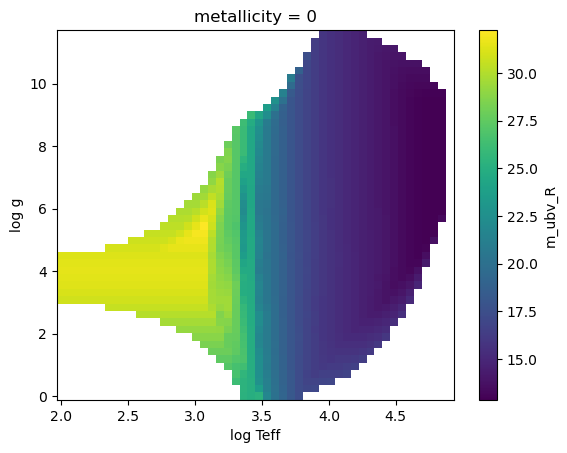

In [14]:
# Choose nearest metallicity slice
plt.figure()
plt.pcolormesh(
    np.log10(Teff_grid),
    logg_grid,
    values[:, :].T,
    shading='auto'
)
plt.xlabel('log Teff')
plt.ylabel('log g')
plt.colorbar(label='m_ubv_R')
plt.title(f'metallicity = 0')
plt.show()